In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math
print(os.getcwd())

# import data
calib_file=os.path.join(os.getcwd(),'_data/calibration_curve.pkl')
df=pd.read_pickle(calib_file)
df.head()

/home/alan/Documents/brewing_and_distilling/distilling_and_whisky_maturation/assignment_two


,Name,retention time [Min],Concentration [ng/ul ],Area
0,Acetaldehyde,2.089,7.00,1.73
1,Ethyl acetate,3.359,6.58,5.16
2,Acetal,3.617,6.64,7.54
3,Methanol,3.848,4.95,47.60
4,Ethanol,4.553,NaN,NaN


In [2]:
compounds=list(df.Name.unique())
compounds.remove('Ethanol')
print(compounds)
istd='Pentanol (ISTD)'

['Acetaldehyde', 'Ethyl acetate', 'Acetal', 'Methanol', 'n-Propanol', 'i-Butanol', 'i-Pentylacetate', 'n-Butanol', 'i-Amylalcohol', 'Pentanol (ISTD)', 'Furfural']


In [3]:
ref_areas=np.array(df[df['Name']==istd]['Area'].dropna())
print(ref_areas)

[31.39 30.   29.87 35.48 24.24 28.3 ]


In [4]:
concs=dict()
rfs=dict()
fits=dict()
for chem in compounds:
    if not chem == istd:
        areas=np.array(df[df['Name']==chem]['Area'].dropna())
        rfs[chem]=areas/ref_areas
        concs[chem]=np.array(df[df['Name']==chem]['Concentration [ng/ul ]'].dropna().astype('float'))
        fits[chem]=np.polyfit(concs[chem],rfs[chem],1)
        
df_fits=pd.DataFrame.from_dict(fits,orient='index')
df_fits.columns=['a','b']
df_fits.head()
calib_fit_mv=os.path.join(os.getcwd(),'_data/calibration_fit_mass_vol.pkl')
df_fits.to_pickle(calib_fit_mv)

In [5]:
font={'family':'sans-serif',
      'size':18,
      'color':'black'
      }

def print_calibration_plot(name):
    line=np.arange(start=0.0, stop=concs[name].max())
    fig,ax=plt.subplots(1,figsize=(10,8))
    ax.scatter(concs[name],rfs[name],label=name)
    fit=fits[name]
    ax.plot(line,fit[0]*line+fit[1],'k:',label='linear fit')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    ax.set_xlabel('{} concentration [ng/ul]'.format(name),fontdict=font)
    ax.set_ylabel('Response factor (Rf)',fontdict=font)
    ax.text(0.0,rfs[name].max(),'linear fit: Rf = {:.4E} conc {} {:.4f}'.format(fits[name][0],
                                                                                '+' if fits[name][1]>0.0 else '-',
                                                                                abs(fits[name][1])),
            fontdict=font)
    pic_file=os.path.join(os.getcwd(),'_output/calibration_{}.png'.format(name))
    plt.savefig(pic_file,bbox_inches='tight')

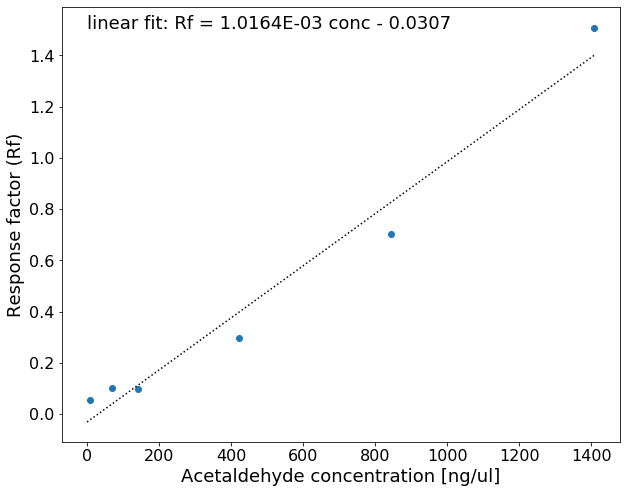

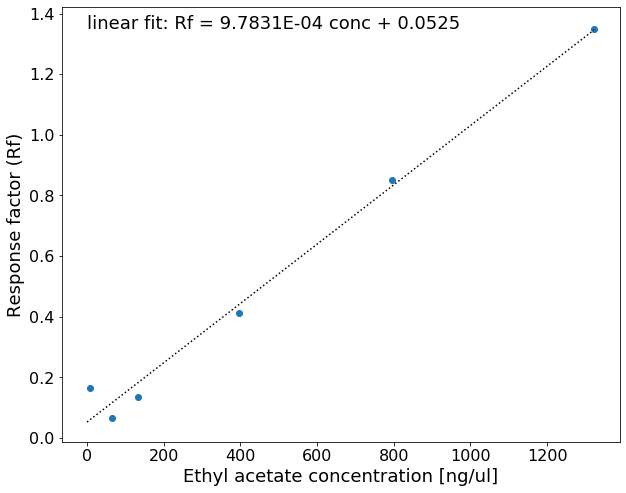

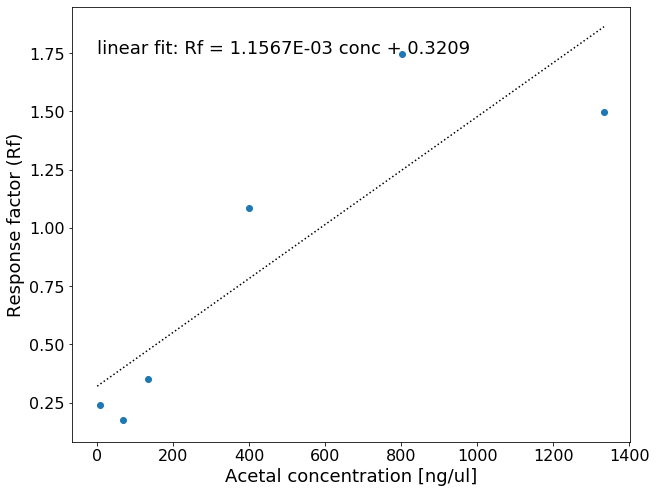

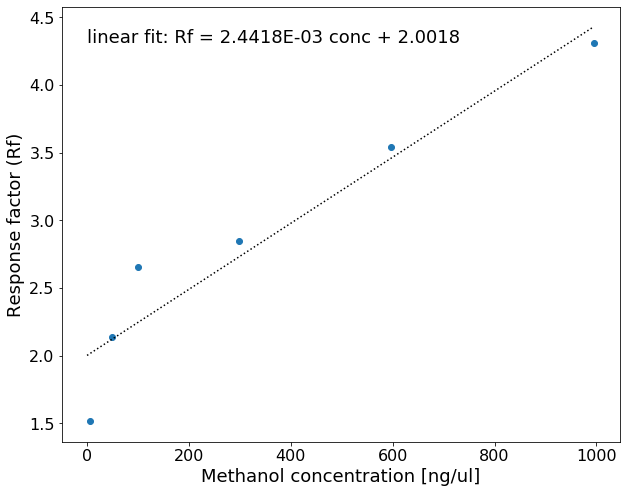

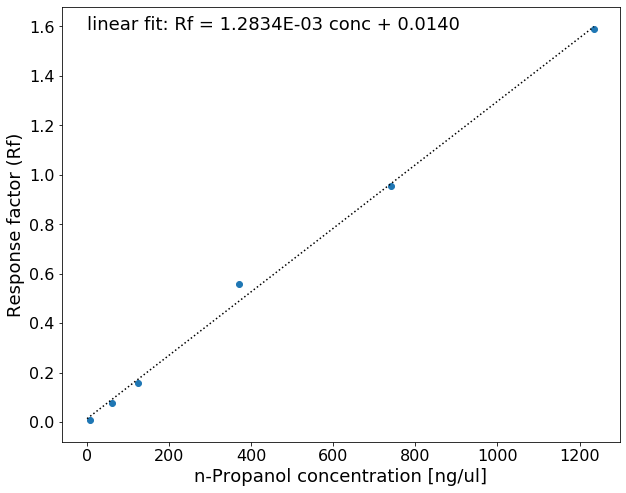

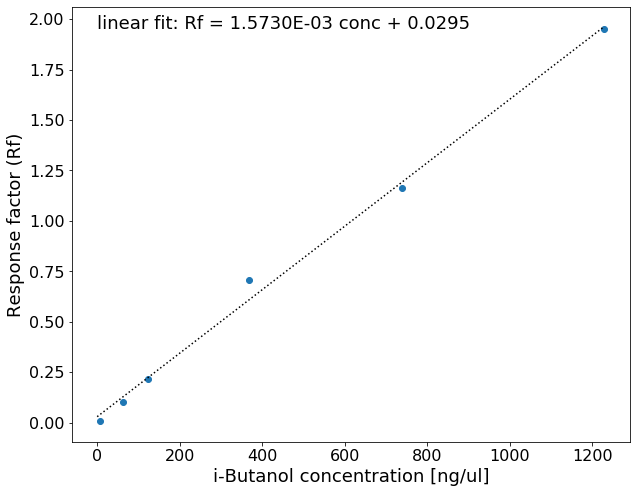

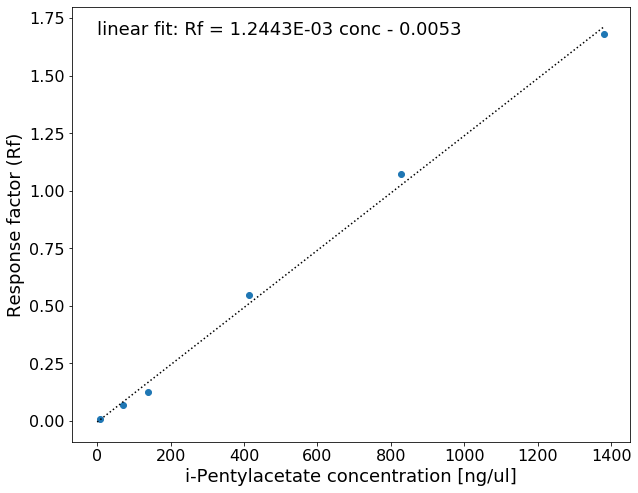

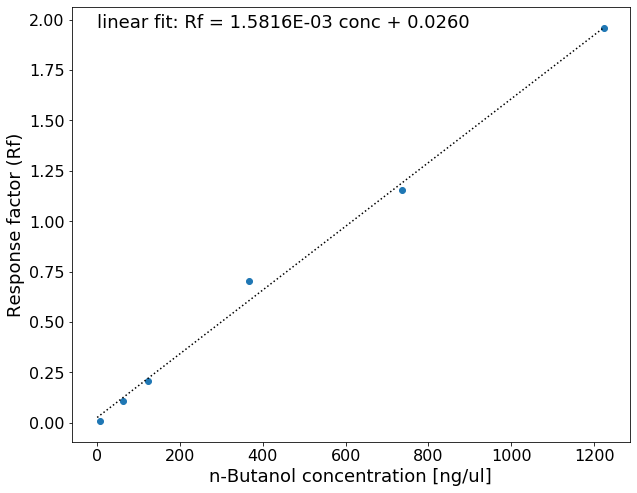

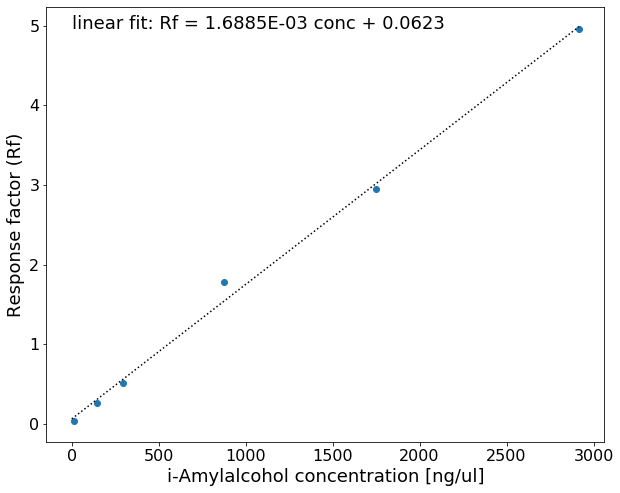

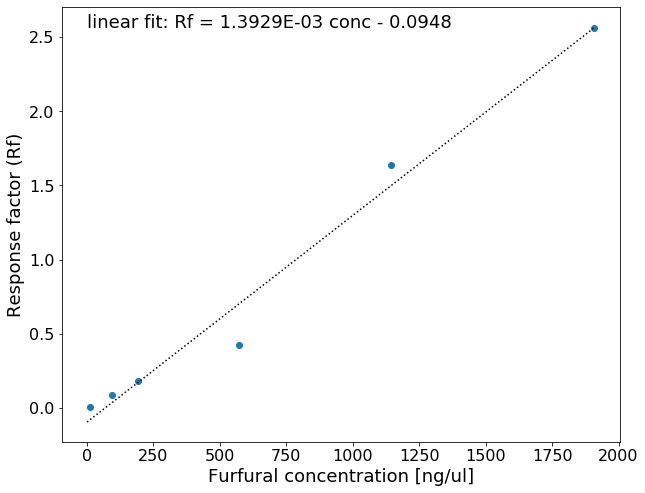

In [6]:
for species in compounds:
    if not species == istd:
        print_calibration_plot(species)

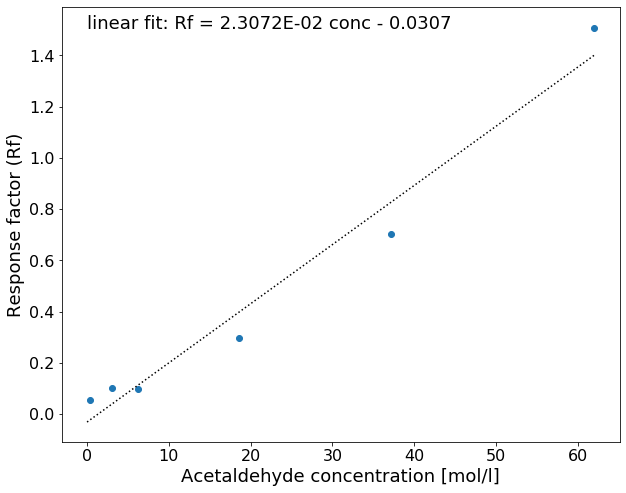

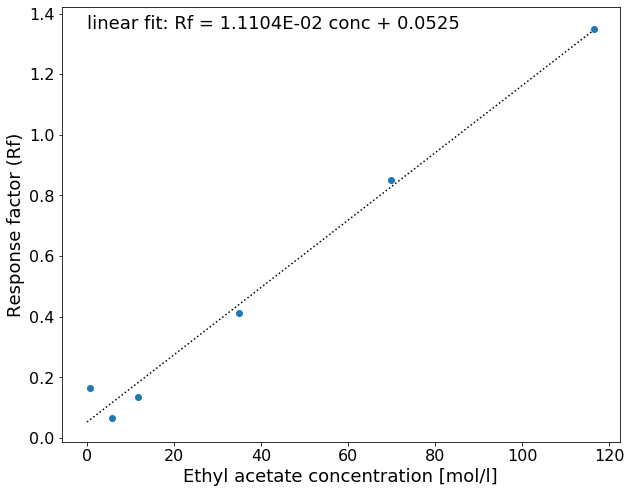

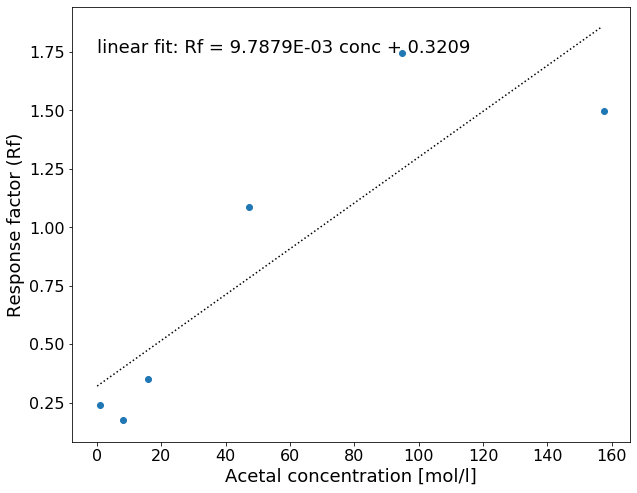

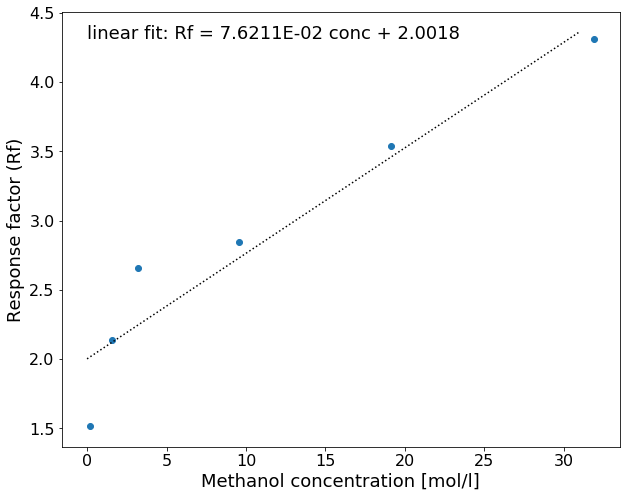

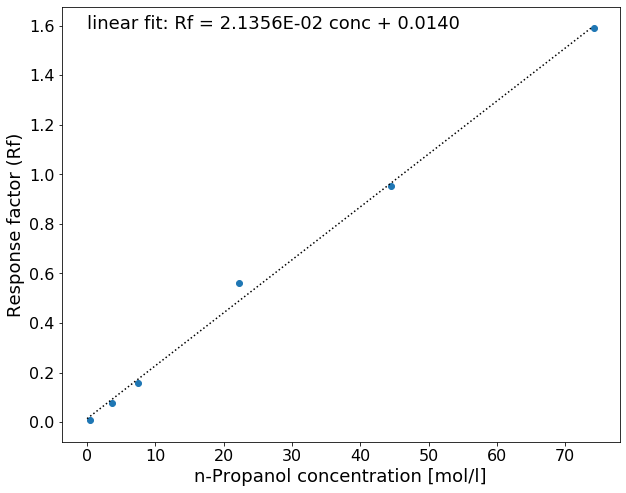

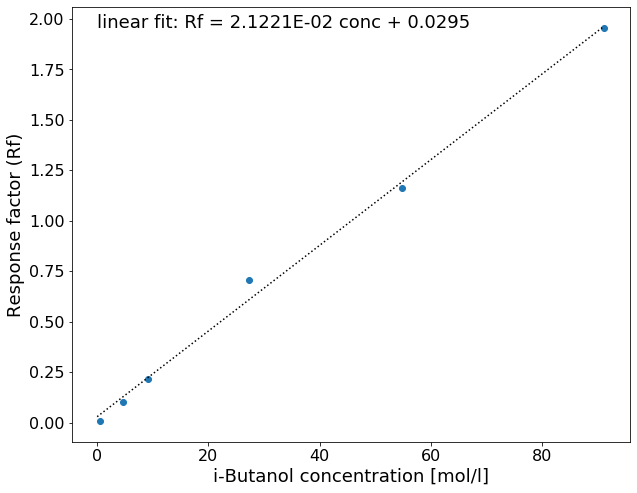

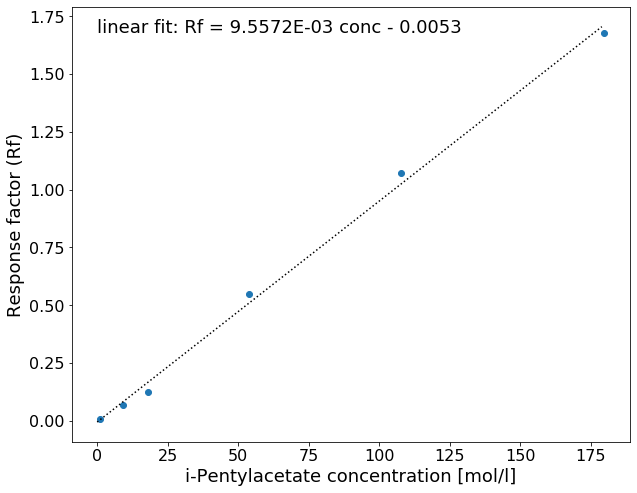

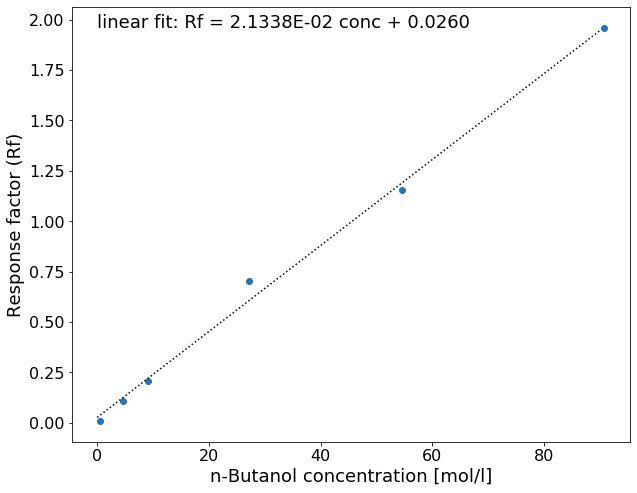

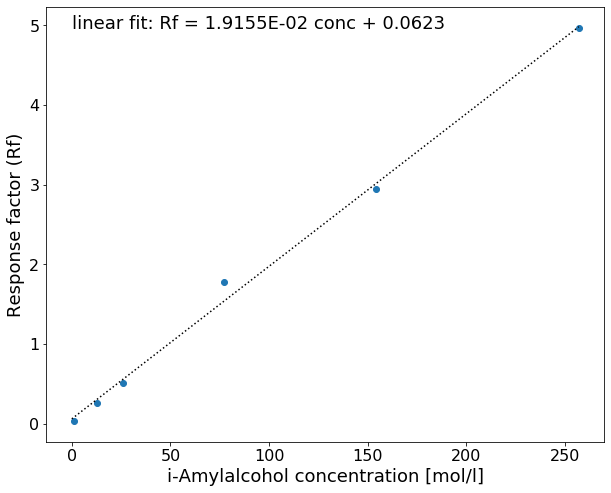

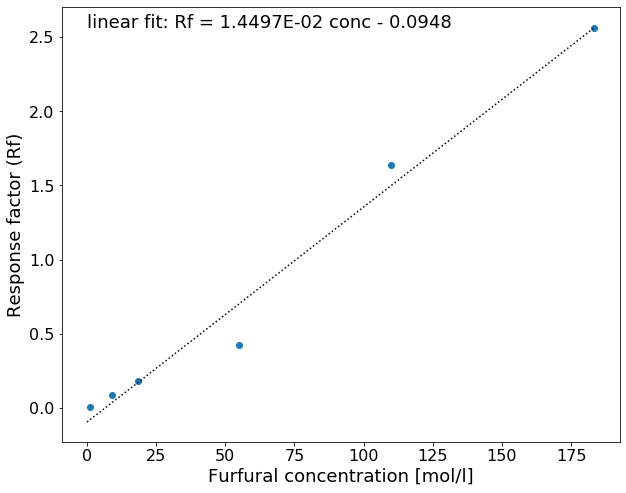

In [7]:
mws={'Acetaldehyde':44.053,
     'Ethyl acetate':88.106,
     'Acetal':118.176, # 1,1-Diethoxyethane
     'Methanol':32.04,
     'n-Propanol':60.096,
     'i-Butanol':74.123,
     'i-Pentylacetate':130.19,
     'n-Butanol':74.123,
     'i-Amylalcohol':88.148,
     'Pentanol (ISTD)':88.150,
     'Furfural':96.085}

molar=dict()
molar_fits=dict()
for chem in compounds:
    if not chem == istd:
        molar[chem]=0.001*np.array(df[df['Name']==chem]['Concentration [ng/ul ]'].dropna().astype('float'))*mws[chem]
        molar_fits[chem]=np.polyfit(molar[chem],rfs[chem],1)
        
df_molar_fits=pd.DataFrame.from_dict(molar_fits,orient='index')
df_molar_fits.columns=['a','b']
calib_fit_molar=os.path.join(os.getcwd(),'_data/calibration_fit_molar.pkl')
df_molar_fits.to_pickle(calib_fit_molar)

def print_molar_calibration_plot(name):
    line=np.arange(start=0.0, stop=molar[name].max())
    fig,ax=plt.subplots(1,figsize=(10,8))
    ax.scatter(molar[name],rfs[name],label=name)
    fit=molar_fits[name]
    ax.plot(line,fit[0]*line+fit[1],'k:',label='linear fit')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    ax.set_xlabel('{} concentration [mol/l]'.format(name),fontdict=font)
    ax.set_ylabel('Response factor (Rf)',fontdict=font)
    ax.text(0.0,rfs[name].max(),'linear fit: Rf = {:.4E} conc {} {:.4f}'.format(molar_fits[name][0],
                                                                                '+' if molar_fits[name][1]>0.0 else '-',
                                                                                abs(molar_fits[name][1])),
            fontdict=font)
    pic_file=os.path.join(os.getcwd(),'_output/molar_calibration_{}.png'.format(name))
    plt.savefig(pic_file,bbox_inches='tight')

for species in compounds:
    if not species == istd:
        print_molar_calibration_plot(species)

In [8]:
def calc_lod(name):
    xs=np.array(concs[name])
    ys=np.array(rfs[name])
    fit=fits[name]
    ys_calc=fit[0]*xs+fit[1]
    residuals=ys_calc-ys
    std_dev=np.std(residuals)
    return 3.0*std_dev/fit[0]

def calc_molar_lod(name):
    xs=np.array(molar[name])
    ys=np.array(rfs[name])
    fit=molar_fits[name]
    ys_calc=fit[0]*xs+fit[1]
    residuals=ys_calc-ys
    std_dev=np.std(residuals)
    return 3.0*std_dev/fit[0]

for species in compounds:
    if not species == istd:
        print('{} LOD: {:.3f} ng/mL [{:.3f} mol/L]'.format(species,calc_lod(species),calc_molar_lod(species)))

Acetaldehyde LOD: 261.622 ng/mL [11.525 mol/L]
Ethyl acetate LOD: 165.537 ng/mL [14.585 mol/L]
Acetal LOD: 784.153 ng/mL [92.668 mol/L]
Methanol LOD: 337.597 ng/mL [10.817 mol/L]
n-Propanol LOD: 73.485 ng/mL [4.416 mol/L]
i-Butanol LOD: 84.294 ng/mL [6.248 mol/L]
i-Pentylacetate LOD: 79.153 ng/mL [10.305 mol/L]
n-Butanol LOD: 82.854 ng/mL [6.141 mol/L]
i-Amylalcohol LOD: 192.011 ng/mL [16.925 mol/L]
Furfural LOD: 287.785 ng/mL [27.652 mol/L]


In [9]:
def choose_subplot_dimensions(k):
    if k < 4:
        return k, 1
    elif k < 11:
        return math.ceil(k/2), 2
    else:
        # I've chosen to have a maximum of 3 columns
        return math.ceil(k/3), 3


def generate_subplots(k, row_wise=False):
    nrow, ncol = choose_subplot_dimensions(k)
    # Choose your share X and share Y parameters as you wish:
    figure, axes = plt.subplots(nrow, ncol,
                                sharex=False,
                                sharey=False,
                               figsize=(16,16))

    # Check if it's an array. If there's only one plot, it's just an Axes obj
    if not isinstance(axes, np.ndarray):
        return figure, [axes]
    else:
        # Choose the traversal you'd like: 'F' is col-wise, 'C' is row-wise
        axes = axes.flatten(order=('C' if row_wise else 'F'))

        # Delete any unused axes from the figure, so that they don't show
        # blank x- and y-axis lines
        for idx, ax in enumerate(axes[k:]):
            figure.delaxes(ax)

            # Turn ticks on for the last ax in each column, wherever it lands
            idx_to_turn_on_ticks = idx + k - ncol if row_wise else idx + k - 1
            for tk in axes[idx_to_turn_on_ticks].get_xticklabels():
                tk.set_visible(True)

        axes = axes[:k]
        return figure, axes

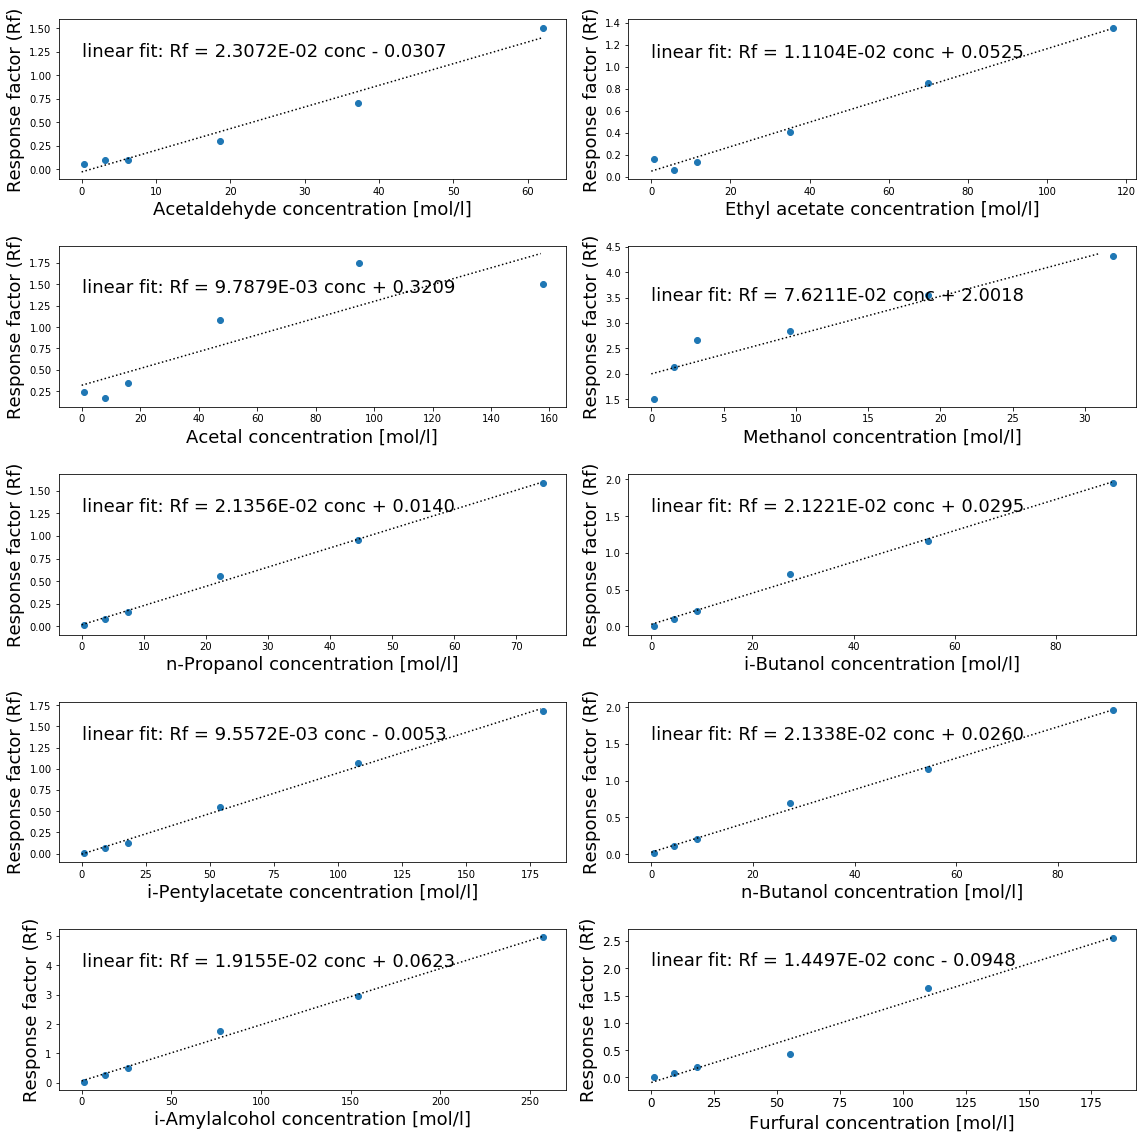

In [10]:
compounds.remove(istd)
figure, axes = generate_subplots(len(compounds), row_wise=True)
    
for species,ax in zip(compounds,axes):
    if not species == istd:
        line=np.arange(start=0.0, stop=molar[species].max())
        ax.scatter(molar[species],rfs[species],label=species)
        fit=molar_fits[species]
        ax.plot(line,fit[0]*line+fit[1],'k:',label='linear fit')
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        ax.set_xlabel('{} concentration [mol/l]'.format(species),fontdict=font)
        ax.set_ylabel('Response factor (Rf)',fontdict=font)
        ax.text(0.0,rfs[species].max()*0.8,'linear fit: Rf = {:.4E} conc {} {:.4f}'.format(molar_fits[species][0],
                                                                                '+' if molar_fits[species][1]>0.0 else '-',
                                                                                abs(molar_fits[species][1])),
                fontdict=font)
        

plt.tight_layout()
pic_file=os.path.join(os.getcwd(),'_output/molar_calibration_all.png')
plt.savefig(pic_file,bbox_inches='tight')
plt.show()

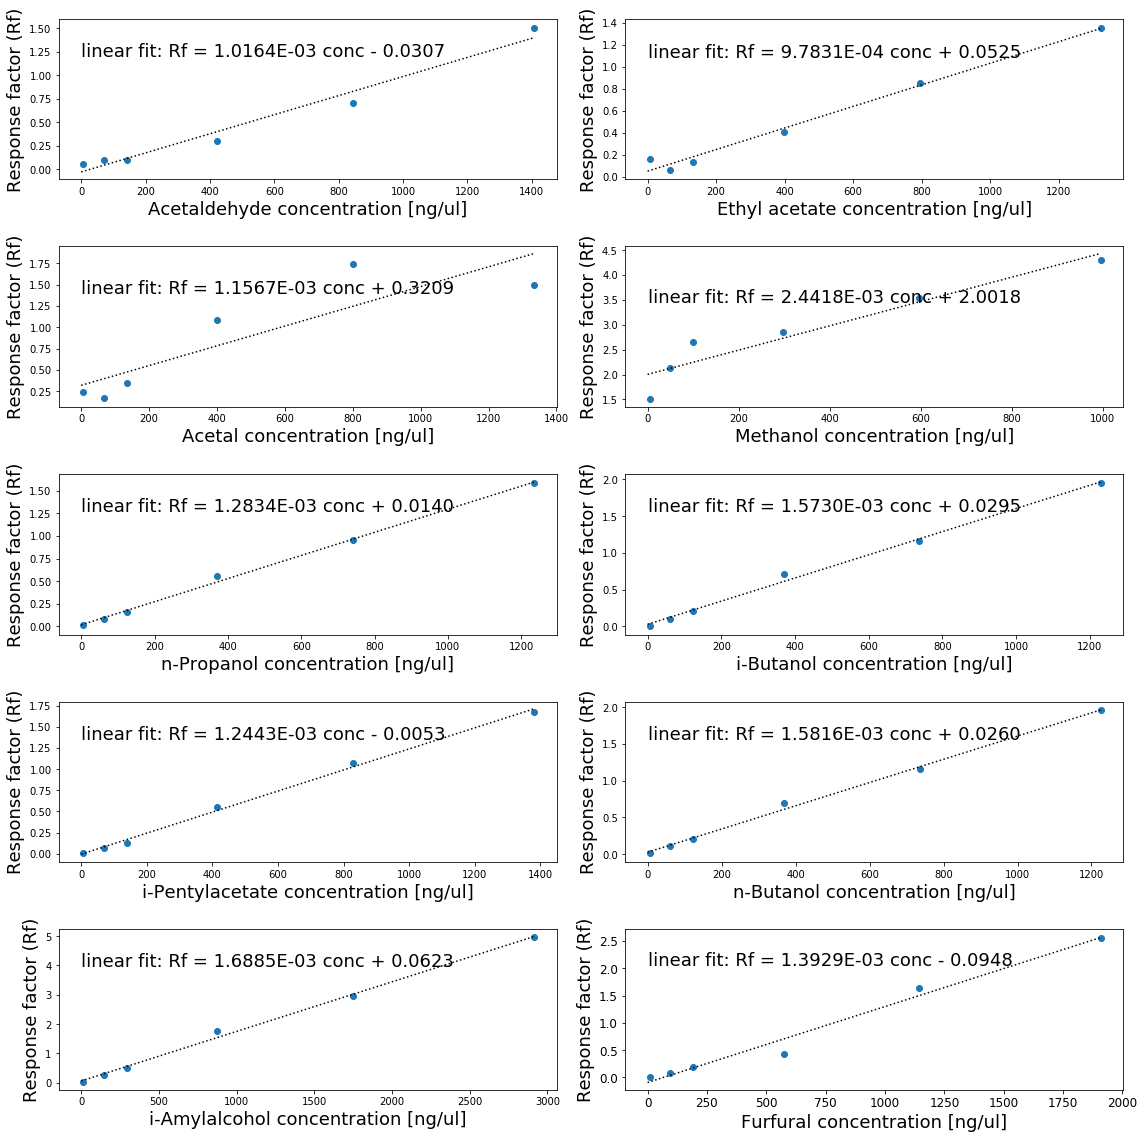

In [11]:
figure, axes = generate_subplots(len(compounds), row_wise=True)
for species,ax in zip(compounds,axes):
    if not species == istd:
        line=np.arange(start=0.0, stop=concs[species].max())
        ax.scatter(concs[species],rfs[species],label=species)
        fit=fits[species]
        ax.plot(line,fit[0]*line+fit[1],'k:',label='linear fit')
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        ax.set_xlabel('{} concentration [ng/ul]'.format(species),fontdict=font)
        ax.set_ylabel('Response factor (Rf)',fontdict=font)
        ax.text(0.0,rfs[species].max()*0.8,'linear fit: Rf = {:.4E} conc {} {:.4f}'.format(fits[species][0],
                                                                                '+' if fits[species][1]>0.0 else '-',
                                                                                abs(fits[species][1])),
                fontdict=font)
        

plt.tight_layout()
pic_file=os.path.join(os.getcwd(),'_output/concs_calibration_all.png')
plt.savefig(pic_file,bbox_inches='tight')
plt.show()

In [13]:
print(fits['Acetal'])

[0.00115669 0.32090194]
